In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
import pandas as pd
from matplotlib.colors import LogNorm
import umap
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset
from oldloader import ThumbnailDataset

from vit_sae_analysis.dashboard_fns import get_new_top_k

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# parent_dir = './cruft/yt-524_288/raw'
# files = [os.path.join(parent_dir, f) for f in os.listdir(parent_dir)]
# files = sorted(files, key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[-1]))

# print(len(files))
# for file in files[:10]:
#     print(file)

# n_ft = 65536
# n_imgs = 400
# device ='cuda'
# max_activating_image_indices = torch.zeros([n_ft, n_imgs]).to(device)
# max_activating_image_values = torch.zeros([n_ft, n_imgs]).to(device)

# for file in files:
#     start_idx = int(file.split('/')[-1].split('.')[0].split('_')[-1])
#     activations = torch.load(file, map_location=device)

#     values, indices = torch.topk(activations, k = min(n_imgs, activations.shape[1]), dim = 1) # sizes [sae_idx, images] is the size of this matrix correct?
#     indices += start_idx

#     max_activating_image_values, max_activating_image_indices = get_new_top_k(max_activating_image_values, max_activating_image_indices, values, indices, n_imgs)
#     print(file, start_idx)
            
# torch.save(max_activating_image_indices, 'cruft/400_max_activating_image_indices.pt')
# torch.save(max_activating_image_values, 'cruft/400_max_activating_image_values.pt')

In [5]:
yt_parent_dir = 'cruft/video/'

yt_files = [os.path.join(yt_parent_dir, f) for f in os.listdir(yt_parent_dir) if f.endswith('.h5')]

ds = ThumbnailDataset(yt_files, 'cpu', ['viewCount'])

In [6]:
views = None

for i, f in enumerate(yt_files):
    data = ds._get_whole_file(i, ['viewCount'])
    if views is None:
        views = data['viewCount']
    else:
        views = torch.cat((views, data['viewCount']))

print(views.shape)

views = views.to(torch.float)
views = views[:524_288]

torch.Size([734619])


In [7]:
# max_vals = torch.load('./cruft/yt-524_288/max_activating_image_values.pt').cpu()
# max_indices = torch.load('./cruft/yt-524_288/max_activating_image_indices.pt').cpu()

max_vals = torch.load('cruft/400_max_activating_image_values.pt', map_location='cpu')
max_indices = torch.load('cruft/400_max_activating_image_indices.pt', map_location='cpu')


print(max_vals.shape)
print(max_indices.shape)

torch.Size([65536, 400])
torch.Size([65536, 400])


In [8]:
means = torch.zeros(max_vals.shape[0])

n_vids_required = 399

for i in range(max_vals.shape[0]):
    if (max_vals[i] > 0.05).sum() > n_vids_required:
        vid_indices = max_indices[i].to(torch.long)
        vid_indices = vid_indices[1:]
        active_vid_views = views[vid_indices.tolist()]

        means[i] = active_vid_views.median()

n_nonzero = (means > 0).sum()
print('number of features active on at least 11 videos:', n_nonzero.item())

topk = torch.topk(means, 100)

torch.set_printoptions(sci_mode=True)
print(topk.values)

mask = means == 0
modified = torch.where(mask, torch.tensor(float('inf')), means)
bottomk = torch.topk(modified, 100, largest=False)

number of features active on at least 11 videos: 952
tensor([3.8685e+04, 3.0013e+04, 2.9349e+04, 2.9290e+04, 2.7361e+04, 2.6509e+04, 2.6474e+04, 2.5900e+04, 2.5039e+04,
        2.5039e+04, 2.4601e+04, 2.4010e+04, 2.3654e+04, 2.2870e+04, 2.2326e+04, 2.2063e+04, 2.2052e+04, 2.1293e+04,
        2.1148e+04, 2.0890e+04, 2.0482e+04, 2.0182e+04, 1.9998e+04, 1.8544e+04, 1.8499e+04, 1.8488e+04, 1.8242e+04,
        1.8017e+04, 1.7711e+04, 1.7554e+04, 1.7295e+04, 1.7280e+04, 1.7017e+04, 1.7011e+04, 1.6639e+04, 1.6471e+04,
        1.6358e+04, 1.6159e+04, 1.5701e+04, 1.5564e+04, 1.5552e+04, 1.5466e+04, 1.5453e+04, 1.5417e+04, 1.5417e+04,
        1.5379e+04, 1.5373e+04, 1.5280e+04, 1.5267e+04, 1.4778e+04, 1.4420e+04, 1.4383e+04, 1.4345e+04, 1.4333e+04,
        1.4191e+04, 1.4172e+04, 1.4161e+04, 1.4128e+04, 1.4113e+04, 1.4049e+04, 1.4026e+04, 1.4016e+04, 1.3674e+04,
        1.3652e+04, 1.3470e+04, 1.3455e+04, 1.3444e+04, 1.3423e+04, 1.3410e+04, 1.3358e+04, 1.3342e+04, 1.3306e+04,
        1.3273e+04,

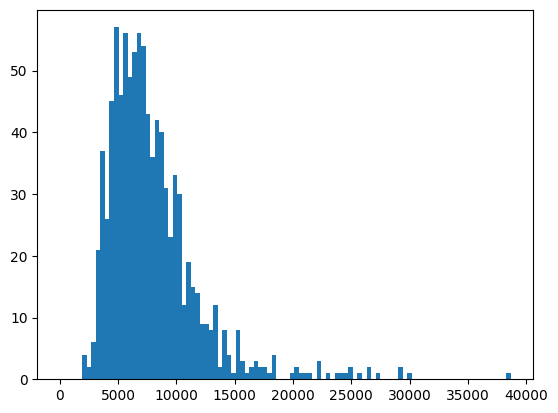

In [9]:
plt.hist(means, range=(1, means.max().item()), bins=100)
print()

In [10]:
rand_means = []
rand_stds = []
for i in range(952):
    rand_idx = torch.randint(0, views.shape[0], (n_vids_required,))

    rand_means.append(views[rand_idx].median())
    rand_stds.append(views[rand_idx].std())

print(f'mean: {np.mean(rand_means):.2e} +- {np.std(rand_means):.2e} --- {np.mean(rand_means) + 2 * np.std(rand_means):.2e}/{np.mean(rand_means) - 2 * np.std(rand_means):.2e}')


mean: 5.97e+03 +- 5.49e+02 --- 7.06e+03/4.87e+03


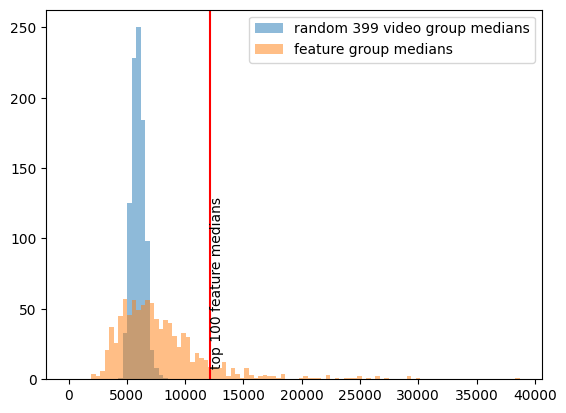

In [12]:
up_to = max(np.max(rand_means).item(), means.max().item()) + 1
plt.hist(rand_means, alpha=0.5, bins=100, range=(1, up_to), label=f'random {n_vids_required} video group medians')
plt.hist(means, alpha=0.5, bins=100, range=(1, up_to), label='feature group medians')

plt.axvline(x=topk.values[99].item(), color='r')
plt.text(topk.values[99].item(), 10, 'top 100 feature medians', rotation=90)
plt.legend()


In [19]:
from scipy import stats

ks_statistic, ks_p_value = stats.ks_2samp(means, rand_means)
ks_statistic, ks_p_value 

(0.98748779296875, 0.0)

5.95e+03, +- 1.16e+03
chance of randomly getting topk mean or higher: %0.0
chance of randomly getting bottomk mean or lower: %0.123


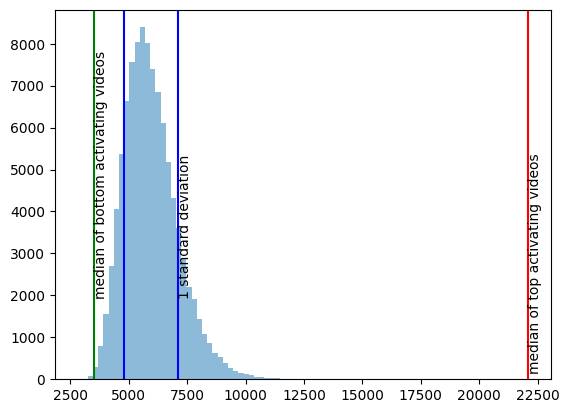

In [13]:
top_views = torch.zeros(100)
for i, feature_idx in enumerate(topk.indices):
    vid_indices = max_indices[feature_idx].to(torch.long)
    active_vid_views = views[vid_indices[0].item()]
    top_views[i] = active_vid_views

top_views_mean = top_views.median()

bottonm_views = torch.zeros(100)

for i, feature_idx in enumerate(bottomk.indices):
    vid_indices = max_indices[feature_idx].to(torch.long)
    active_vid_views = views[vid_indices[0].item()]
    bottonm_views[i] = active_vid_views

bottonm_views_mean = bottonm_views.median()

rand_11 = []
for i in range(100_000):
    rand_views = views[torch.randint(0, views.shape[0], (100,))]
    rand_11.append(rand_views.median())

print(f'{np.mean(rand_11):.2e}, +- {np.std(rand_11):.2e}')

plt.hist(rand_11, alpha=0.5, bins=50)

plt.axvline(np.mean(rand_11) + np.std(rand_11), color='b')
plt.axvline(np.mean(rand_11) - np.std(rand_11), color='b')

plt.axvline(top_views_mean, color='r')
p = (np.array(rand_11) > top_views_mean.item()).sum() / len(rand_11)

print(f"chance of randomly getting topk mean or higher: %{p * 100}", )


plt.text(np.mean(rand_11) + np.std(rand_11), 2000,  '1 standard deviation', rotation=90)
plt.text(top_views_mean, 200,  'median of top activating videos', rotation=90)

plt.axvline(bottonm_views_mean, color='g')
p = (np.array(rand_11) < bottonm_views_mean.item()).sum() / len(rand_11)

print(f"chance of randomly getting bottomk mean or lower: %{p * 100}", )

plt.text(bottonm_views_mean, 2000,  'median of bottom activating videos', rotation=90)

plt.show()


In [11]:
def show_images(tensor_images, pil_images, num_cols=4, save_path='path/to/save/grid.png', show=False):
    transform = transforms.ToPILImage()
    
    # Determine the grid dimensions
    num_tensor_rows = (len(tensor_images) + num_cols - 1) // num_cols  # Compute rows needed for tensor images
    num_pil_rows = (len(pil_images) + num_cols - 1) // num_cols        # Compute rows needed for PIL images
    num_rows = num_tensor_rows + num_pil_rows                         # Total rows

    # Determine height and width from the first tensor image if available, else from the first PIL image

    height = tensor_images[0].shape[0]
    width = tensor_images[0].shape[1]

    # Create a blank grid image
    grid_image = Image.new('RGB', (width * num_cols, height * num_rows))

    # Insert tensor images into the grid
    for i, img_tensor in enumerate(tensor_images):
        img = transform(img_tensor.permute(2, 0, 1))  # Adjust tensor for PIL and convert to image
        x = i % num_cols * width
        y = i // num_cols * height
        grid_image.paste(img, (x, y))

    # Insert PIL images directly below the last row of tensor images
    for j, img in enumerate(pil_images):
        x = j % num_cols * width
        y = (j // num_cols + num_tensor_rows) * height  # Adjust y to start after the tensor image rows
        grid_image.paste(img, (x, y))

    # Save the grid image to disk
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    grid_image.save(save_path)
    print(f'Grid image saved: {save_path}')

    if show:
        # Display the grid image
        plt.figure(figsize=(15, 10))
        plt.imshow(grid_image)
        plt.axis('off')
        plt.show()

In [12]:
n_top = 100
ds = ThumbnailDataset(yt_files, 'cpu', ['thumbnailStandard'])

ims = []
for i in topk.indices[:n_top]:
    images = []
    vid_indices = max_indices[i].to(torch.long)
    for j in vid_indices[:11]:
        images.append(ds[j]['thumbnailStandard'])

    ims.append(images)

all_vid_tensors = [torch.stack(i).squeeze() for i in ims]

In [14]:
imgnet_max_indices = torch.load('cruft/imgnet_dash/max_activating_image_indices.pt', map_location='cpu')
imgnet = load_dataset("evanarlian/imagenet_1k_resized_256", split='train')
imgnet = imgnet.shuffle(seed=1)

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/39 [00:00<?, ?it/s]

In [80]:
for i, feature_idx in enumerate(bottomk.indices[:n_top]):
    vid_tensors = all_vid_tensors[i]
    imgnet_indices = imgnet_max_indices[feature_idx][:11]

    imgnet_imgs = []
    for idx in imgnet_indices:
        img = imgnet[int(idx.item())]['image']
        imgnet_imgs.append(img)

    show_images(vid_tensors, imgnet_imgs, 4, f"cruft/images/yt_bottom_{i}_grid_image.png", show=False)


Grid image saved: cruft/images/yt_bottom_0_grid_image.png
Grid image saved: cruft/images/yt_bottom_1_grid_image.png
Grid image saved: cruft/images/yt_bottom_2_grid_image.png
Grid image saved: cruft/images/yt_bottom_3_grid_image.png
Grid image saved: cruft/images/yt_bottom_4_grid_image.png
Grid image saved: cruft/images/yt_bottom_5_grid_image.png
Grid image saved: cruft/images/yt_bottom_6_grid_image.png
Grid image saved: cruft/images/yt_bottom_7_grid_image.png
Grid image saved: cruft/images/yt_bottom_8_grid_image.png
Grid image saved: cruft/images/yt_bottom_9_grid_image.png
Grid image saved: cruft/images/yt_bottom_10_grid_image.png
Grid image saved: cruft/images/yt_bottom_11_grid_image.png
Grid image saved: cruft/images/yt_bottom_12_grid_image.png
Grid image saved: cruft/images/yt_bottom_13_grid_image.png
Grid image saved: cruft/images/yt_bottom_14_grid_image.png
Grid image saved: cruft/images/yt_bottom_15_grid_image.png
Grid image saved: cruft/images/yt_bottom_16_grid_image.png
Grid im

In [36]:
torch.set_printoptions(sci_mode=False)
views.median()

tensor(5918.)

Grid image saved: cruft/top_100imgs.png


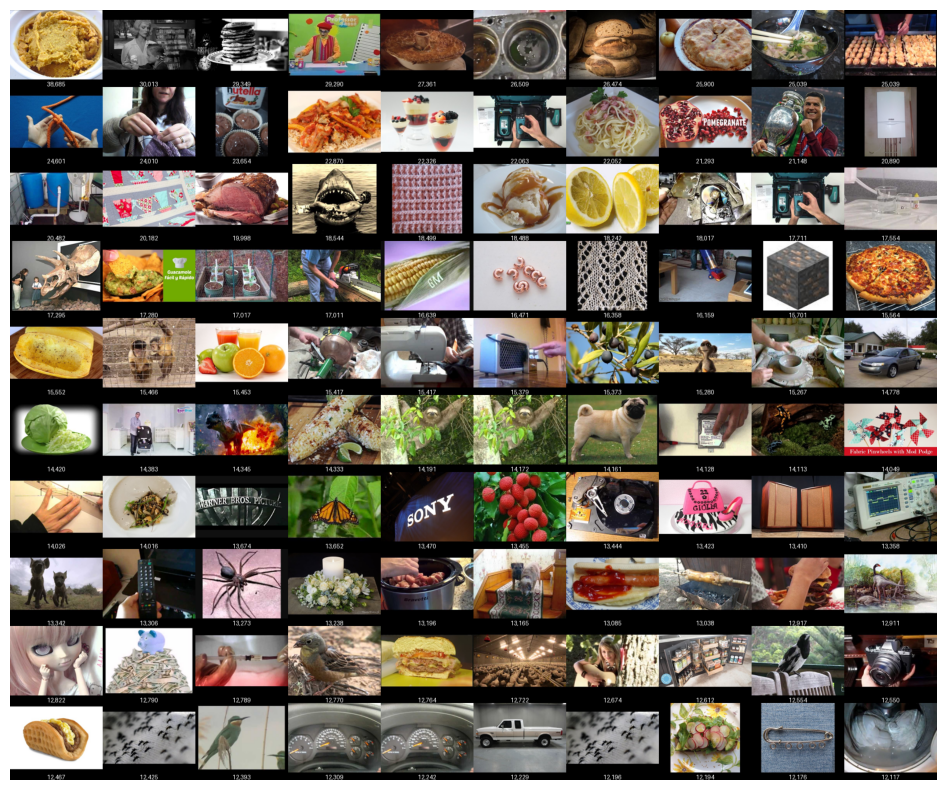

In [28]:
from PIL import Image, ImageDraw, ImageFont

import torch
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
from packaging import version

def show_tensor_grid_with_labels(tensor_images, labels, save_path='path/to/save/grid.png', show=False):
    import PIL

    transform = transforms.ToPILImage()
    num_cols = 10
    num_rows = 10

    # Ensure the number of images and labels match
    assert len(tensor_images) == len(labels) == num_cols * num_rows, "The number of images and labels must be 100."

    # Assuming all images are the same size
    # Get image dimensions from the first tensor image
    height = tensor_images[0].shape[0]
    width = tensor_images[0].shape[1]

    # 1. Scale down the images by a factor of 10
    new_height = height // 3
    new_width = width // 3

    # 2. Set font size proportional to new image height
    font_size = max(int(new_height * 0.5), 10)  # Ensure a minimum font size for readability
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        # If arial.ttf is not found, use default font
        font = ImageFont.load_default()

    # Determine Pillow version for compatibility
    pillow_version = PIL.__version__

    # Calculate the space needed for the labels
    text_sample = '0'
    if version.parse(pillow_version) >= version.parse("10.0.0"):
        # For Pillow >= 10.0.0
        bbox = font.getbbox(text_sample)
        text_height = bbox[3] - bbox[1]
    else:
        # For Pillow < 10.0.0
        text_width, text_height = font.getsize(text_sample)
    label_height = text_height + 5  # Add some padding

    # Create a blank grid image with extra space for labels
    grid_image = Image.new('RGB', (new_width * num_cols, (new_height + label_height) * num_rows))

    # Insert tensor images and labels into the grid
    for i, (img_tensor, label) in enumerate(zip(tensor_images, labels)):
        # Adjust tensor for PIL and convert to image
        img = transform(img_tensor.permute(2, 0, 1))
        # 1. Resize image to 1/10th of its original size
        img = img.resize((new_width, new_height))

        x = (i % num_cols) * new_width
        y = (i // num_cols) * (new_height + label_height)

        # Paste the image
        grid_image.paste(img, (x, y))

        # Draw the label below the image
        draw = ImageDraw.Draw(grid_image)
        # 3. Round the label and format with commas
        rounded_label = round(label)
        text = f"{rounded_label:,}"

        if version.parse(pillow_version) >= version.parse("10.0.0"):
            # For Pillow >= 10.0.0
            bbox = font.getbbox(text)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
        else:
            # For Pillow < 10.0.0
            text_width, text_height = font.getsize(text)

        text_x = x + (new_width - text_width) / 2
        text_y = y + new_height + 2  # Slight offset from the image

        # Add a rectangle behind the text for better visibility
        rect_x0 = x
        rect_y0 = y + new_height
        rect_x1 = x + new_width
        rect_y1 = rect_y0 + label_height
        draw.rectangle([rect_x0, rect_y0, rect_x1, rect_y1], fill=(0, 0, 0))

        # Draw the text over the rectangle
        draw.text((text_x, text_y), text, font=font, fill=(255, 255, 255))

    # Save the grid image to disk
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    grid_image.save(save_path)
    print(f'Grid image saved: {save_path}')

    if show:
        # Display the grid image
        plt.figure(figsize=(15, 10))
        plt.imshow(grid_image)
        plt.axis('off')
        plt.show()

top_tensors = [vi[0] for vi in all_vid_tensors]

show_tensor_grid_with_labels(top_tensors, topk.values.tolist(), 'cruft/top_100imgs.png', show=True)

In [24]:
n_top = 100
ds = ThumbnailDataset(yt_files, 'cpu', ['thumbnailStandard'])

ims = []
for i in bottomk.indices[:n_top]:
    images = []
    vid_indices = max_indices[i].to(torch.long)
    for j in vid_indices[:11]:
        images.append(ds[j]['thumbnailStandard'])
        

    ims.append(images)

bot_vid_tensors = [torch.stack(i).squeeze() for i in ims]

Grid image saved: cruft/bot_100imgs.png


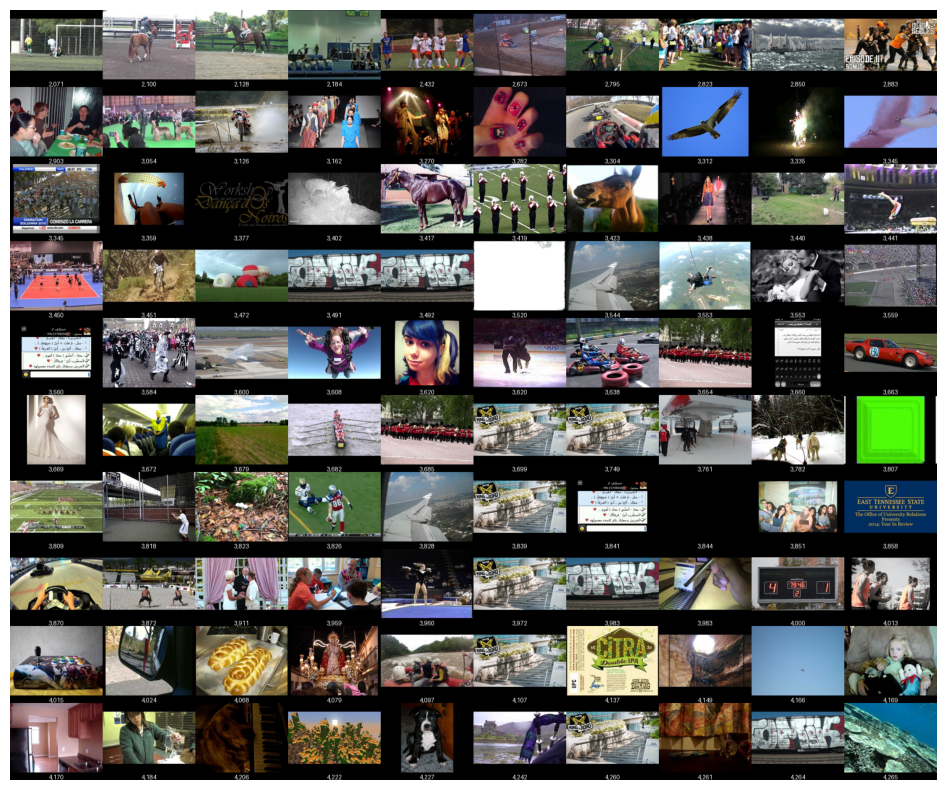

In [27]:
bot_tensors = [vi[0] for vi in bot_vid_tensors]

show_tensor_grid_with_labels(bot_tensors, bottomk.values.tolist(), 'cruft/bot_100imgs.png', show=True)